In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import myPreprocessors as mypp #nuestra librerías de transformaciones.

In [3]:
import joblib

# Objetivo del modelo

Predecir el genero de la persona. Predecir en que clase viajó

# 1 - Carga de datos

In [4]:
dataset_original = pd.read_csv("data/train.csv")

In [5]:
dataset_original.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2 - Análisis

### 2.1 - Funciones análisis

In [6]:
def generarHistograma(data, columna):
    plt.hist((data[columna]).astype(str))
    plt.title(columna)
    plt.show()

In [7]:
def generarHistogramaDensidad(data, columna):
    sns.displot(data[columna], kde=True, color = "darkblue")

In [8]:
def obtenerVariables(data):
    discretas = []
    continuas = []
    categoricas = []

    for columna in data.columns:
        if (data[columna].dtype == "object"):
            categoricas.append(columna)
        else:
            if (len(data[columna].unique()) <= 30):
                discretas.append(columna)
            else:
                continuas.append(columna)
    
    return categoricas, discretas, continuas

### 2.2 - Exploración

In [9]:
dataset_original.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
dataset_original.shape

(891, 12)

In [11]:
dataset_original.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
dataset_original.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


##### Determina tipos de variables

In [13]:
categoricas, discretas, continuas = obtenerVariables(dataset_original)

##### Categóricas

In [14]:
categoricas

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [15]:
dataset_original[categoricas]

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S
...,...,...,...,...,...
886,"Montvila, Rev. Juozas",male,211536,NaN,S
887,"Graham, Miss. Margaret Edith",female,112053,B42,S
888,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,NaN,S
889,"Behr, Mr. Karl Howell",male,111369,C148,C


Por el tipo de dato que aportan las variables Name y Ticket se pueden excluir dado que no aportarán al modelo. Por la cantidad de valores na que contiene Cabin también puede ser descartada.

In [16]:
categoricas.remove("Name")

In [17]:
categoricas.remove("Ticket")

In [18]:
categoricas.remove("Cabin")

In [19]:
categoricas

['Sex', 'Embarked']

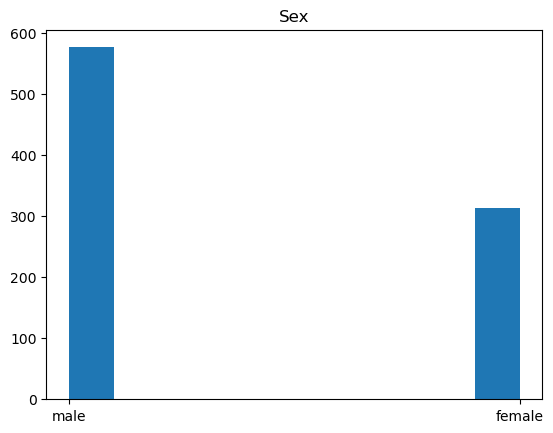

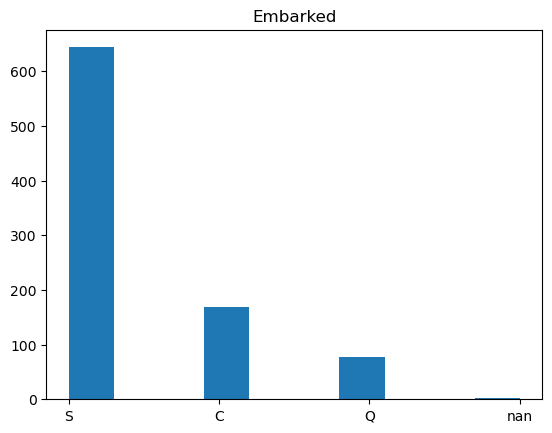

In [20]:
for columna in categoricas:
    generarHistograma(dataset_original, columna)

Dado que la variable Sex es la que interesa precedir, hay que aplicarle un mapping y a la variable embarked, imputación por missing 

##### Discretas

In [21]:
discretas

['Survived', 'Pclass', 'SibSp', 'Parch']

In [22]:
dataset_original[discretas]

,Survived,Pclass,SibSp,Parch
0,0,3,1,0
1,1,1,1,0
2,1,3,0,0
3,1,1,1,0
4,0,3,0,0
...,...,...,...,...
886,0,2,0,0
887,1,1,0,0
888,0,3,1,2
889,1,1,0,0


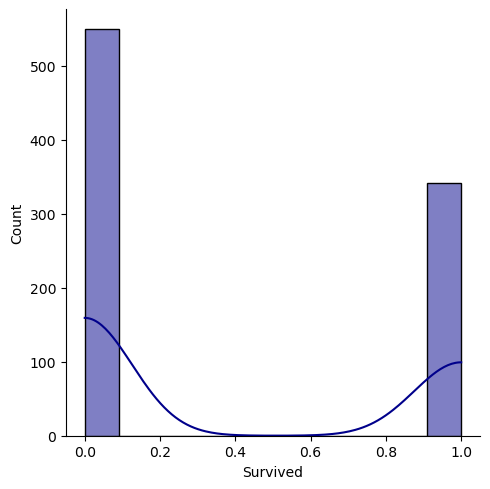

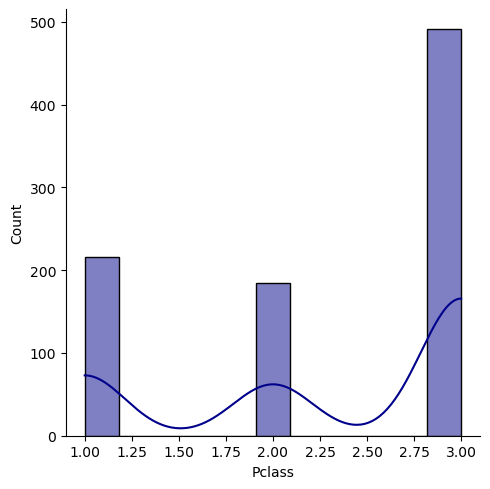

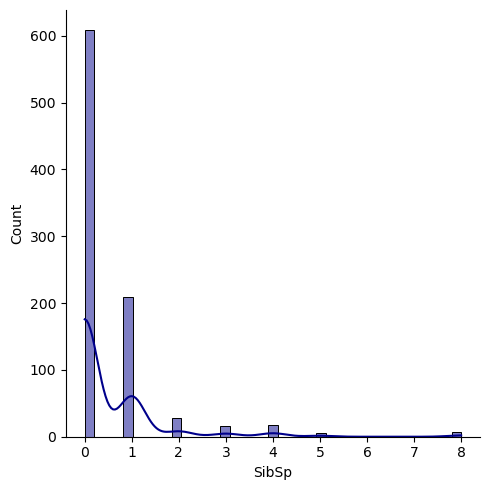

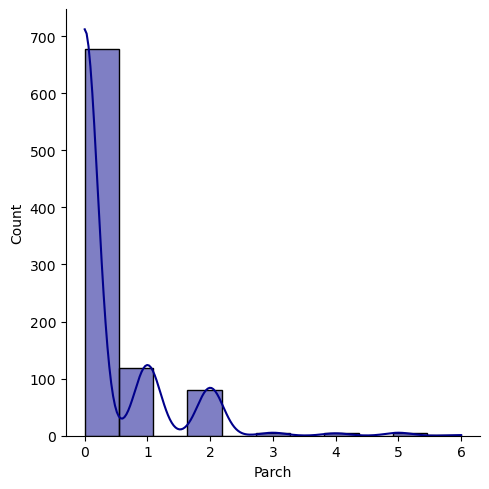

In [23]:
for columna in discretas:
    generarHistogramaDensidad(dataset_original, columna)

Las variables SibSp y Parch estan bastante desbalanceadas, por lo podria consideras obviarles o aplicarles tratamiento de outliers

##### Continuas

In [24]:
continuas

['PassengerId', 'Age', 'Fare']

La variable PassengerId se omite por ser el identificador

In [25]:
continuas.remove("PassengerId")

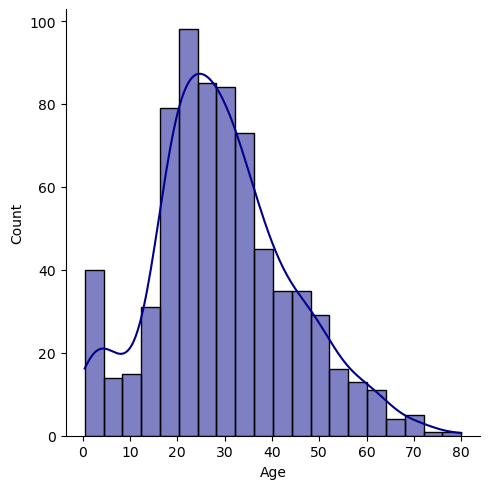

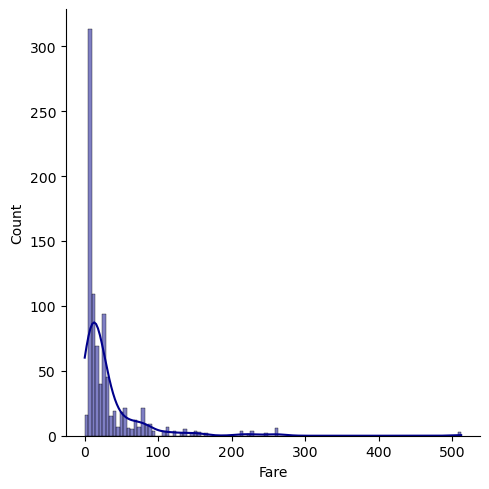

In [26]:
for columna in continuas:
    generarHistogramaDensidad(dataset_original, columna)

La varariable esta desbalanceada por tanto requier tratamiento de outliers. Estas variables puede aplicarse transformación logaritmica.

# 3 - Preparación Datasets y PCA - Regresión logistica

### 3.1 - Nuevo dataset y Mapeo target

In [27]:
dataset = dataset_original.copy()
target = "Sex"

In [28]:
map_target = {"female": 0, "male": 1}

In [29]:
dataset[target] = dataset[target].map(map_target)

### 3.2 - Definiendo Features

In [30]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


In [31]:
features = ["Survived","Pclass","Age", "SibSp", "Parch", "Fare", "Embarked"]
dropFeatures = ["PassengerId", "Name", "Ticket", "Cabin"]

#### 3.3 - PCA

In [32]:
dataPCA = dataset[features]

dataPCA["Embarked"].fillna("Missing", inplace= True)
dataPCA["Embarked"] = dataPCA["Embarked"].map({"Missing":0, "NA": 0, "nan":0, "C":1, "S":2, "Q":3})


dataPCA["Age"].fillna(dataPCA["Age"].mean(skipna=True), inplace=True)
dataPCA["Age"] = np.log(dataPCA["Age"])
dataPCA["Fare"] = np.log(dataPCA["Fare"])

dataPCA["Fare"].replace([np.inf, -np.inf], np.nan, inplace=True)
dataPCA["Fare"].fillna(0, inplace=True)


/var/folders/hh/25c_zdz92t9c70mlh69s5tg80000gn/T/ipykernel_59789/2002608201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataPCA["Embarked"].fillna("Missing", inplace= True)
/var/folders/hh/25c_zdz92t9c70mlh69s5tg80000gn/T/ipykernel_59789/2002608201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataPCA["Embarked"] = dataPCA["Embarked"].map({"Missing":0, "NA": 0, "nan":0, "C":1, "S":2, "Q":3})
/var/folders/hh/25c_zdz92t9c70mlh69s5tg80000gn/T/ipykernel_59789/2002608201.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [33]:
dataPCA.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
0,0,3,3.091042,1,0,1.981001,2
1,1,1,3.637586,1,0,4.266662,1
2,1,3,3.258097,0,0,2.070022,2
3,1,1,3.555348,1,0,3.972177,2
4,0,3,3.555348,0,0,2.085672,2


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    dataPCA,
    dataset[target],
    test_size=0.3,
    random_state=2022)

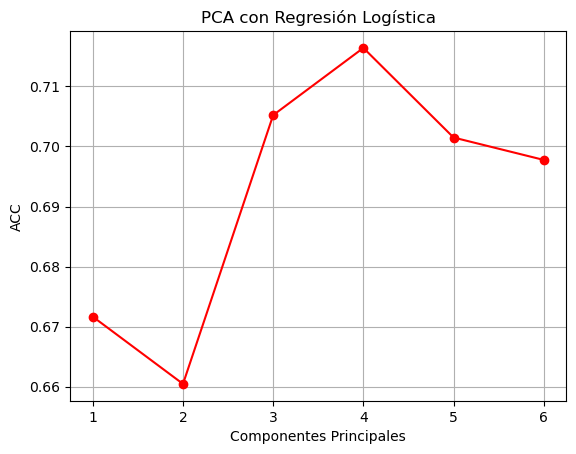

In [35]:
pcas = np.arange(1, 7)
accs = []

for pca in pcas:
    #Calculo PCA
    pca = PCA(n_components=pca)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    #entrenamiento del modelo
    rlog_clf_pca = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
    rlog_clf_pca.fit(X_train_pca, y_train)
    preds_rlog_pca = rlog_clf_pca.predict(X_test_pca)
    acc = accuracy_score(y_test, preds_rlog_pca)
    accs.append(acc)

plt.grid()
plt.plot(pcas, accs, "-o", color="red")
plt.title("PCA con Regresión Logística")
plt.xlabel("Componentes Principales")
plt.ylabel("ACC")
plt.xticks(pcas)
plt.show()

##### PCA - Regresión Logística. Componentes = 4

In [36]:
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
rlog_clf_pca = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000 )
rlog_clf_pca.fit(X_train_pca, y_train)
preds_rlog_pca = rlog_clf_pca.predict(X_test_pca)
accuracy_score(y_test, preds_rlog_pca)

0.7164179104477612

### 3.4 - Train Test Split para Entrenamiento y Prueba

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_original.drop(["Sex"], axis=1),
    dataset[target],
    test_size=0.3,
    random_state=2022)

# 4 - Configuración Pipeline

In [75]:
variables_catetogoricas_con_na_missing = ["Embarked"]

variables_numericas_con_na = ["Age"]

variables_numericas_log = ["Age", "Fare"]

variables_encoding_ordinal = ["Embarked"]

map_encoding_ordinal = {"Missing":0, "NA": 0, "C":1, "S":2, "Q":3}

features = ["Survived","Pclass","Age", "SibSp", "Parch", "Fare", "Embarked", "PassengerId", "Name", "Ticket", "Cabin"]

# 5 - Pipeline

In [65]:
titanicSex_pipeline_v122022 = Pipeline([
    #1. Drop de variables.
    ('drop_time_features',
        DropFeatures(features_to_drop=dropFeatures)
    ),

    #2. Imputaciín de variables categóricas con indicador de faltante
    ('missing_imputation',
        CategoricalImputer(imputation_method='missing', variables=variables_catetogoricas_con_na_missing)
    ),

    #3. Ordinal encoding.
    ('quality_mapper',
        mypp.Mapper(variables=variables_encoding_ordinal, mappings=map_encoding_ordinal)
    ),

    #4. Indicador faltane en variables numericas para imputación
    ('missing_indicator_numeric',
        AddMissingIndicator(variables=variables_numericas_con_na)
    ),
    
    #5. Imputación de variables numéricas
    ('mean_imputation',
        MeanMedianImputer(imputation_method='mean', variables=variables_numericas_con_na)
    ),

    #6. Transformación logaritmica
    #('log_transformer',
     #   LogTransformer(variables=variables_numericas_log)
    #),

    #=============== SCALER ============
    ('scaler',
        MinMaxScaler()
    ),

    #=============== PCA y Regresión ============
    ('pca',
    PCA(n_components= 4)),
    ('regresion_logistica',
    LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000 ))
])

In [66]:
titanicSex_pipeline_v122022.fit(X_train, y_train)

Pipeline(steps=[('drop_time_features',
                 DropFeatures(features_to_drop=['PassengerId', 'Name', 'Ticket',
                                                'Cabin'])),
                ('missing_imputation',
                 CategoricalImputer(variables=['Embarked'])),
                ('quality_mapper',
                 Mapper(mappings={'C': 1, 'Missing': 0, 'NA': 0, 'Q': 3,
                                  'S': 2},
                        variables=['Embarked'])),
                ('missing_indicator_numeric',
                 AddMissingIndicator(variables=['Age'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Age'])),
                ('scaler', MinMaxScaler()), ('pca', PCA(n_components=4)),
                ('regresion_logistica',
                 LogisticRegression(max_iter=1000, random_state=0))])

In [67]:
preds = titanicSex_pipeline_v122022.predict(X_test)

In [68]:
rmseTest = np.sqrt(mean_squared_error((y_test), (preds)))
rmseTest

0.4530164242022743

In [69]:
np.min((y_train)), np.max((y_train))

(0, 1)

In [70]:
rmseTest / (np.max((y_train)) - np.min((y_train)))

0.4530164242022743

In [71]:
test = pd.DataFrame({"target": y_test, "predicción": preds})
test

,target,predicción
770,1,1
178,1,1
786,0,0
159,1,1
656,1,1
...,...,...
693,1,1
79,0,0
71,0,1
503,0,1


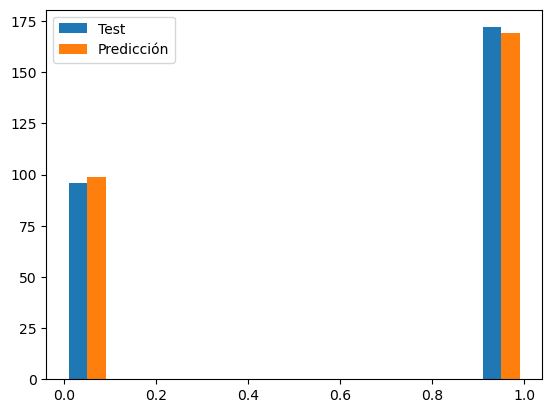

In [72]:
plt.hist(test, label= ["Test","Predicción"])
plt.legend()
plt.show()

In [73]:
np.sum(pca.explained_variance_ratio_)

0.8719078141753821

# 6 - Exportar modelo

In [74]:
joblib.dump(titanicSex_pipeline_v122022, 'titanicSex_pipeline_v122022.pkl')

['titanicSex_pipeline_v122022.pkl']

In [76]:
joblib.dump(features, 'FEATURES.pkl')

['FEATURES.pkl']